# Objetivo

Agrupar bots por assunto


## Query mensagens

In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
query = """

select 
msg.id_issue
, msg.dt_envio_mensagem
, nm_entidade
, msg.ds_message
, novas_tags.hierarquia_4
, novas_tags.fila_de_atendimento
from cx_curated_zone.helpshift_issues_messages msg
left join "cx_curated_zone"."helpshift_issues" AS issues_macro ON msg."id_issue" = issues_macro."id_issue"
left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON msg."id_issue" = helpshift_tag."id_issue"
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
where ds_entidade = 'bot'
and dt_envio_mensagem >= to_date('2022-06-01','yyyy-mm-dd')
order by rand() desc
limit 50000

"""

df = ac.df_athena('flavia-costa', query)

## Funções de tratamento

In [3]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text

In [4]:
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))

In [5]:
def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

In [6]:
def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

In [7]:
stopwords= ['não','nao',  'da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um', 'ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 
            'mim', 'então', 'aqui', 'tô', 'pro', 'isso', "protocolo", "acesse","abre" ,"tela", "finalizar", "sistema", "instavel", "desculpe", "problemas","ja" , "chamo", "chamar", 
            "vou", "equipe", "alguma", "duvida", "precisa", "ajuda", "responder", "respondi", "legal", "te ajudar", "certo", "certinho", "opcoes", "clique", "clicar", "will",
            "willbank", "dias", "uteis", "infelizmente", "alguns","algum", "r$","agilizar", "diz", "breve","posso", "pode", "puder", "escolhe", "assunto","momento","consigo","poxa","pena",
            "encontra", "encontrar","pessoa","enquanto","problema","poderia","veja","dessas","saber","estao","assuntos","procurados","nunca","pede","documento","vale","lembrar","trouxe","continuar",
            "deles", "confirma", "atender", "atendimento", "aguarde", "rapido", "possivel", "quer", "sera", "possivel", "tranquilo", "alguem","nossa","te","ter","com",'gente',
            "vamos", "antes", "falar", "somente", "numeros", "iniciar", "conversa", "ajudar", "detalhar", "melhor", "coisa", "importante"
            ]

## Tratando texto da mensagem

In [8]:
df['ds_message_tratada'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(remove_emoji)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)

## substituindo endereços pela palavra 'endereço'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("rua"), 'endereço', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("cep"), 'endereço', df['ds_message_tratada'])

## substituindo links pela palavra 'url'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("https"), 'url', df['ds_message_tratada'])

## Substituido todos os códigos pela palavra 'código' - os código encontrados continham wi5, wi9, wi8, yf ou bc
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi5"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi9"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi8"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("bc"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("yf"), 'código', df['ds_message_tratada'])
##Tratando algumas palavras
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('ª', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('º', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace(' r ', ' ')

## protocolo / ate dias / voce pode 
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("protocolo"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("ate dias"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("voce pode"), '', df['ds_message_tratada'])

## fatura
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('faturas', 'fatura')

#espacos final
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)

df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')

## Clusterização

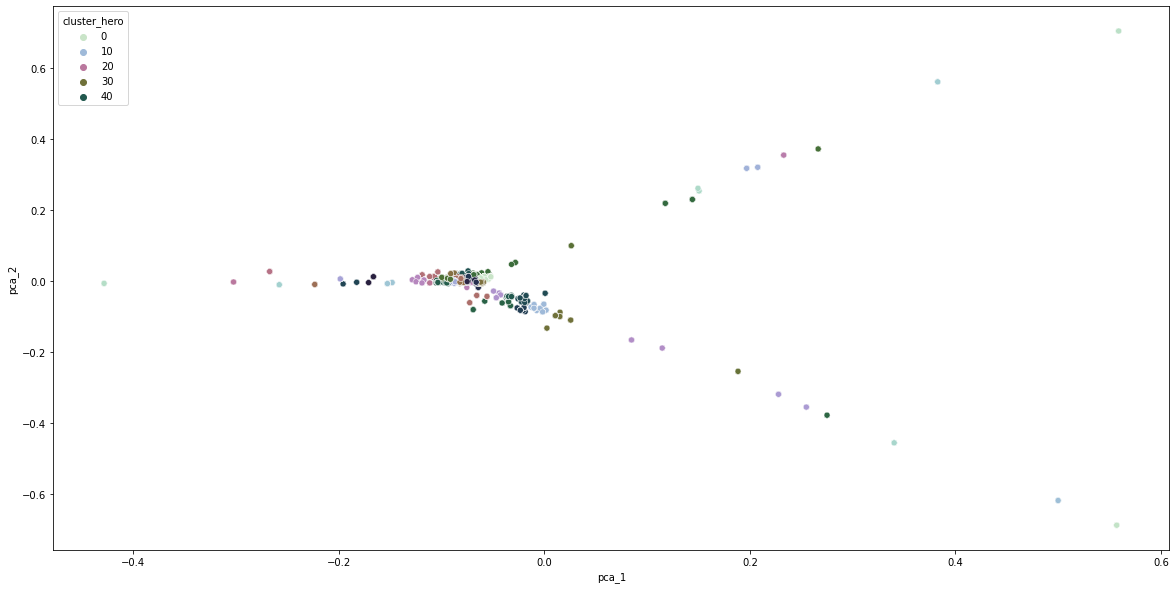

In [9]:
## Clusterização com tfidf pacote text hero  + K-means
import texthero as hero

df_clean['pca'] = (
   df_clean['ds_message_tratada']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)

df_clean['pca_1'] = df_clean['pca'].astype('string').str.split(",").str[1]
df_clean['pca_2'] = df_clean['pca'].astype('string').str.split(",").str[0]

for i in ['pca_1','pca_2']:
    df_clean[i] = df_clean[i].str.replace(']','').str.replace('[','').astype("float")

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50).fit(df_clean[['pca_1','pca_2']])
cluster = kmeans.predict(df_clean[['pca_1','pca_2']])

df_clean['cluster_hero'] = cluster
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean, x = 'pca_1', y = 'pca_2', hue='cluster_hero', palette="ch:s=1,rot=-2")
plt.show()

In [10]:
cl = [7,2,12]

for i in cl:
    print("================= CLUSTER " + str(i) + "===========")
    print(df_clean[['cluster_hero','ds_message_tratada']][df_clean['cluster_hero'] == i].value_counts(normalize=True))

================= CLUSTER 7===========
cluster_hero  ds_message_tratada
7             qual fatura           1.0
dtype: float64
================= CLUSTER 2===========
cluster_hero  ds_message_tratada
2             qual                  1.0
dtype: float64
================= CLUSTER 12===========
cluster_hero  ds_message_tratada                                                                                                                                                                        
12            lembrando mudamos plastico do cartao porem ainda tera funcao contactless (pagamento aproximacao) cartao virtual deseja dar continuidade solicitacao                                           0.247423
              vi cartao esta bloqueado recebeu esta maos                                                                                                                                                    0.132875
              desbloquear cartao vai na inicial do app "gerenciar cartoes"     

## N-grams pelo pacote arabica

In [11]:
def ranking_cluster(df_clean, cluster,texto):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'cluster'])
    
    for i in df_clean[cluster].unique():
        try:
            df_clean_tmp = df_clean[df_clean[cluster] == i ]
            df_agg_ungroup_tmp = arabica_freq(
                text = df_clean_tmp[texto],
                time = df_clean_tmp['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 10,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True) 
            
            result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                        'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                        'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
            
            result_temp['cluster'] = i
                    
            df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

        except IndexError:
            pass
                
    return df_agg_ungroup_final

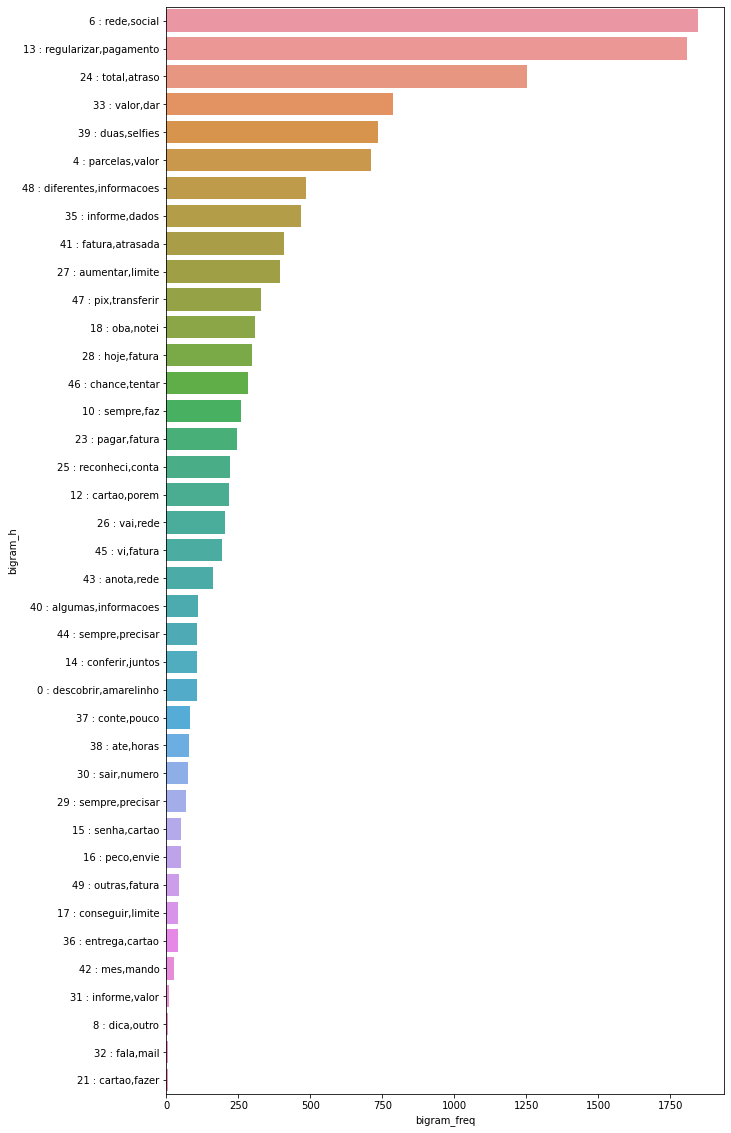

In [15]:
df_resumo = ranking_cluster(df_clean, 'cluster_hero', 'ds_message_tratada')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

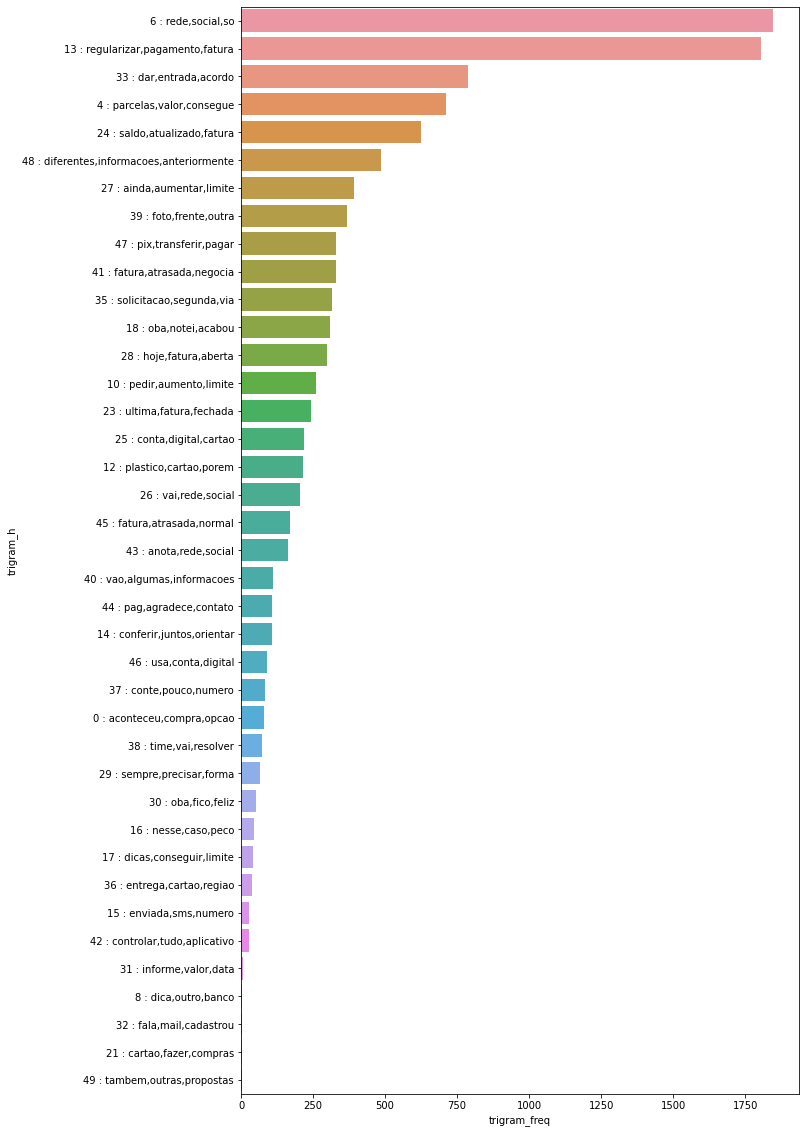

In [16]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

In [ ]:
df_clean.head()

,id_issue,dt_envio_mensagem,nm_entidade,ds_message,hierarquia_4,fila_de_atendimento,ds_message_tratada,pca,pca_1,pca_2,cluster_hero
0,10209270,2022-07-03 18:38:19,BOT | Cobrança < 120,Aguarde que vamos te responder o mais r&aacute...,Parcelamento de fatura,Pagamento,)mas anote numero do do,"[0.4659928860302017, 0.33548333465169045]",0.335483,0.465993,5
1,11397004,2022-09-08 19:47:42,bot will - limite de crédito (2),Ainda n&atilde;o d&aacute; pra aumentar limite...,Devolução,Logistica,ainda aumentar limite no,"[-0.0015255405688603405, -0.0853021660923999]",-0.085302,-0.001526,15
3,11757968,2022-09-28 13:31:32,BOT | Cobrança > 120,"E para parcelas, qual é o valor (somente númer...",Parcelamento de fatura,Pagamento,parcelas qual valor ( ) consegue pagar mes,"[-0.2571314285487704, 0.14992279577000886]",0.149923,-0.257131,0
4,13044193,2022-12-05 18:43:38,bot pag - Logística - Segunda via - Reconhecim...,Vamos responder você o mais rápido possível. E...,Segunda via cartão,Logistica,endereco,"[0.002030861133612382, -0.07245626974174997]",-0.072456,0.002031,31
6,11153146,2022-08-24 20:33:35,bot will - migração,"Pra pagar uma fatura fechada, volta na tela in...",Dúvidas sobre pagamento de fatura,Pagamento,pagar fatura fechada volta na inicial,"[-0.01946815715854011, -0.07824832788763565]",-0.078248,-0.019468,21


In [17]:
df_clean['nm_entidade_clean'] = df_clean['nm_entidade'].str.replace('(1)', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('(2)', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('(3)', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('(4)', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.lower()
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('- geral', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('>', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('<', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('bot', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('pag ', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('will ', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('|', '')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].str.replace('  ', ' ')
df_clean['nm_entidade_clean'] = df_clean['nm_entidade_clean'].apply(clean_text)

In [18]:
pd.crosstab(df_clean['nm_entidade_clean'], df_clean['fila_de_atendimento'], normalize="columns")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
nm_entidade_clean,,,,,,,,,
alterar senha do app,0.000000,0.0016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
alterar senha do cartao,0.000000,0.0168,0.000000,0.000000,0.001722,0.000000,0.000000,0.000110,0.000000
bloqueio,0.000000,0.0192,0.000735,0.001943,0.011481,0.002581,0.003826,0.001434,0.008333
bloqueio erro senha maquininha,0.000000,0.0048,0.000000,0.000000,0.000287,0.000000,0.000000,0.000000,0.000000
bloqueio fde,0.000000,0.0248,0.000000,0.000833,0.049082,0.000968,0.006886,0.000552,0.000000
...,...,...,...,...,...,...,...,...,...
router limite,0.000000,0.0000,0.000000,0.000555,0.000000,0.004677,0.000000,0.000110,0.002083
segunda via do cartao (),0.001250,0.0040,0.000000,0.000278,0.002583,0.000806,0.039786,0.000110,0.000000
senhatoken,0.000000,0.0024,0.000000,0.000555,0.001148,0.000323,0.000000,0.000000,0.000000


In [19]:
df_resumo_entidade = arabica_freq(
                text = df_clean['nm_entidade_clean'],
                time = df_clean['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 50,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True)

In [ ]:
df_resumo_entidade

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,cobranca,8358,"fila,geral",6162,"fila,geral,faq",6125
1,geral,6222,"geral,faq",6125,"logistica,segunda,via",2101
2,fila,6162,"menu,inicial",3604,"via,reconhecimento,compra",2099
3,faq,6125,"segunda,via",2349,"segunda,via,reconhecimento",2099
4,logistica,4706,"logistica,segunda",2101,"cobranca,solicitacao,duvidas",2026
5,fatura,4198,"via,reconhecimento",2099,"solicitacao,duvidas,landing",2026
6,inicial,3604,"reconhecimento,compra",2099,"duvidas,landing,page",2026
7,menu,3604,"cobranca,solicitacao",2026,"pagamento,parcelar,fatura",556
8,compra,2990,"solicitacao,duvidas",2026,"parcelar,fatura,api",556
9,duvidas,2755,"duvidas,landing",2026,"bloqueio,lista,restritiva",385


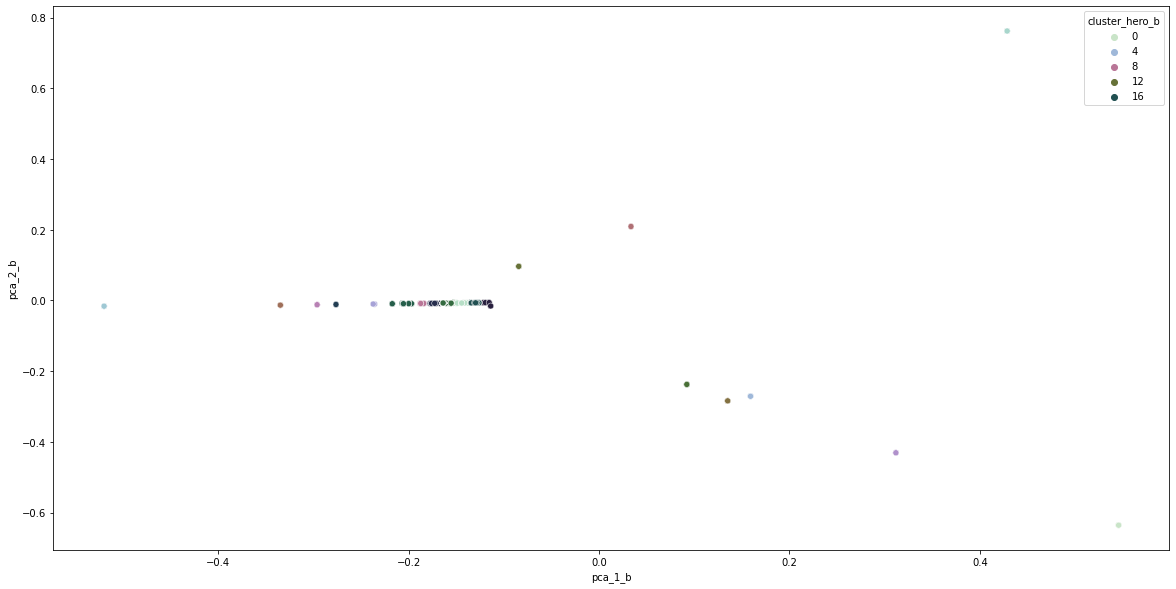

In [20]:
df_clean['pca'] = (
   df_clean['nm_entidade_clean']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)

df_clean['pca_1_b'] = df_clean['pca'].astype('string').str.split(",").str[1]
df_clean['pca_2_b'] = df_clean['pca'].astype('string').str.split(",").str[0]

for i in ['pca_1_b','pca_2_b']:
    df_clean[i] = df_clean[i].str.replace(']','').str.replace('[','').astype("float")

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20).fit(df_clean[['pca_1_b','pca_2_b']])
cluster = kmeans.predict(df_clean[['pca_1_b','pca_2_b']])

df_clean['cluster_hero_b'] = cluster
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean, x = 'pca_1_b', y = 'pca_2_b', hue='cluster_hero_b', palette="ch:s=1,rot=-2")
plt.show()

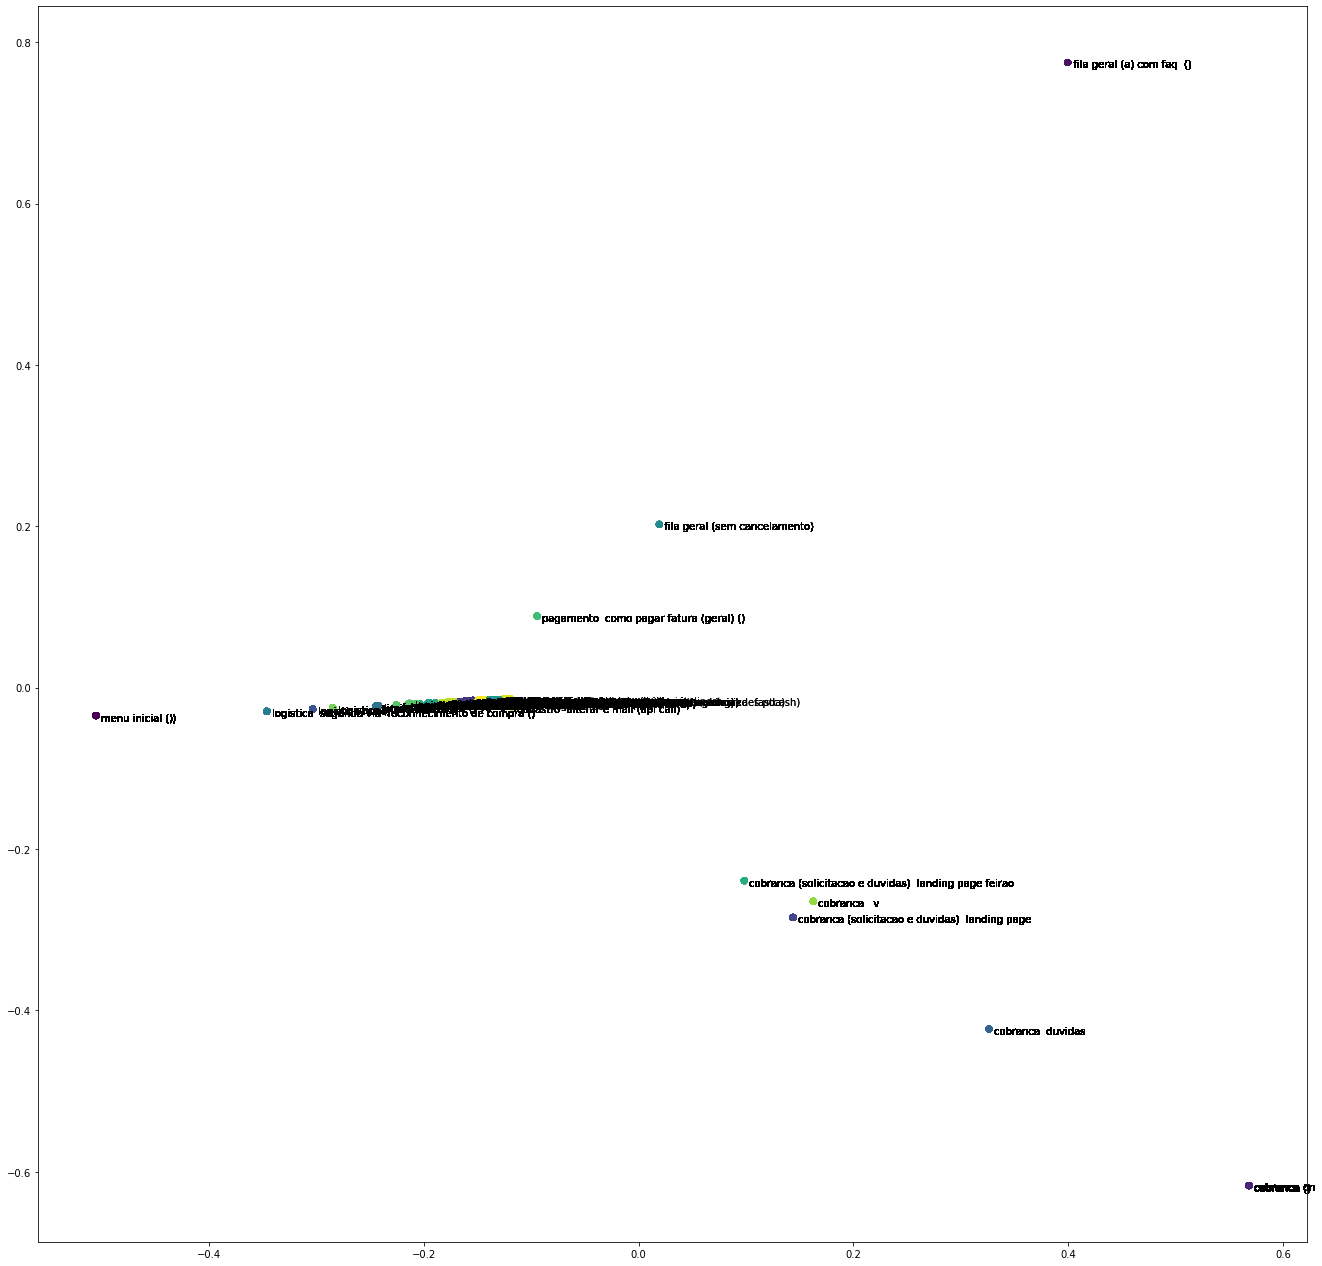

In [ ]:
plt.figure(figsize=(50,50))
plt.subplot(223)
x = df_clean['pca_1_b']
y = df_clean['pca_2_b']

plt.scatter(x, y, c=df_clean['cluster_hero_b'])

labels = df_clean['nm_entidade_clean']

for label, x, y in zip(labels, x, y):
    plt.annotate(label, xy=(x, y), xytext=(5, -5), textcoords='offset points')

plt.show()

Identificadas ate o momento

- menu inicial
- relacionamento: boas vindas + retencao + mapa
- fila geral
- cobranca + bloqueio por atraso
- pagamento
- logistica + segunda via + bloqueio fde nao entregue
- fatura + dia de fechamento + melhor dia
- limite
- gamificacao + conta pura
- cadastro + nao recebeu o token + senha token + alterar senha do app + validar selfie + bloqueio o desbloqueio
- pix + depositosaqueted
- uso_cartao: compra duplicada + desbloqueio de cartao + compra solicitar cancelamento + compra + compra estorno + cartao virtual + senha cartao + erro senha
- migracao
- fraude: fraude + bloqueio fde + bloqueio lista restritiva + nrc curto + nrc longo + bloqueio
- informacoes outros produtos: 'cashback', 'tarifas', 'emprestimo ()', fgts, tarifas  saque
- pesquisa



In [21]:
def clean_nm_bot(x):
    x = unidecode(x)
    x = x.lower()
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.replace('- geral', '')
    x = x.replace('>', '')
    x = x.replace('<', '')
    x = x.replace('bot', '')
    x = x.replace('pag ', '')
    x = x.replace('will ', '')
    x = x.replace('|', '')
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

def classifica_bots(x):
        
    if "menu inicial" in x:
        return "Menu Inicial"   
    
    elif "pesquisa" in x:
        return "Pesquisa"
    
    elif "fila geral" in x:
        return "Fila Geral"
    
    
    elif "compra" in x:
        return "Uso do Cartão"
    elif "desbloqueio do cartao" in x:
        return "Uso do Cartão"
    elif "solicitar cancelamento" in x:
        return "Uso do Cartão"
    elif "cartao virtual" in x:
        return "Uso do Cartão"
    elif "senha cartao" in x:
        return "Uso do Cartão"
    elif "erro senha" in x:
        return "Uso do Cartão"

    elif "pagamento" in x:
        return "Pagamento"

    elif "pix" in x:
        return "Pix/Ted"
    elif "depositosaqueted" in x:
        return "Pix/Ted"
    elif " ted " in x:
        return "Pix/Ted"
    elif "transferencia bancaria" in x:
        return "Pix/Ted"
    
    elif "fraude" in x:
        return "Fraude"
    elif "bloqueio" in x:
        return "Fraude"
    elif "lista restritiva" in x:
        return "Fraude"
    elif "nrc curto" in x:
        return "Fraude"
    elif "nrc longo" in x:
        return "Fraude"

    elif "cobranca" in x:
        return "Cobrança"
    elif "bloqueio por atraso" in x:
        return "Cobrança"
    
    elif "emprestimo" in x:
        return "Economia / liquidez"
    elif "tarifas" in x:
        return "Economia / liquidez"
    elif "fgts" in x:
        return "Economia / liquidez"
    elif "saque" in x:
        return "Economia / liquidez"
    
    elif "cashback" in x:
        return "Marketplace"  
    
    elif "fatura" in x:
        return "Fatura"
    elif "dia de fechamento" in x:
        return "Fatura"
    elif "melhor dia" in x:
        return "Fatura"
      
    elif "boas vindas" in x:
        return "Relacionamento"
    elif "retencao" in x:
        return "Relacionamento"
    elif "mapa" in x:
        return "Relacionamento"
    elif "migracao" in x:
        return "Relacionamento"
    
    elif "cadastro" in x:
        return "Cadastro"
    elif "token" in x:
        return "Cadastro"
    elif "senha do app" in x:
        return "Cadastro"
    elif "validar selfie" in x:
        return "Cadastro"
    elif "bloqueio o desbloqueio" in x:
        return "Cadastro"
    
    
    elif "logistica" in x:
        return "Logística"
    elif "segunda via" in x:
        return "Logística"
    elif "nao entregue" in x:
        return "Logística"
    
    elif "limite" in x:
        return "Limite"
    
    elif "gamificacao" in x:
        return "Alternativas Credito"
    elif "conta pura" in x:
        return "Alternativas Credito"

    else:
        return "Outros"

In [22]:
df_clean['hierarquia_bots'] = df_clean['nm_entidade'].apply(clean_nm_bot).apply(classifica_bots)

In [23]:
df_clean['hierarquia_bots'].value_counts(normalize=True)

Cobrança                0.219712
Fila Geral              0.158621
Uso do Cartão           0.102908
Menu Inicial            0.096580
Fatura                  0.084584
Logística               0.075197
Limite                  0.057822
Fraude                  0.052126
Alternativas Credito    0.041738
Relacionamento          0.035700
Pix/Ted                 0.034408
Pagamento               0.018377
Outros                  0.014053
Cadastro                0.005300
Economia / liquidez     0.002162
Marketplace             0.000580
Pesquisa                0.000132
Name: hierarquia_bots, dtype: float64

In [ ]:
df_clean[['hierarquia_bots', 'id_issue']].groupby('hierarquia_bots').count()

,id_issue
hierarquia_bots,
Alternativas Credito,1644
Cadastro,238
Cobrança,8358
Economia / liquidez,75
Fatura,3201
Fila Geral,6162
Fraude,1870
Limite,2180
Logística,2855


In [ ]:
df_clean['fila_de_atendimento'].value_counts(normalize=True)

Pagamento    0.277560
Geral        0.192487
Logistica    0.117665
Fatura       0.116161
Fraude       0.106617
Bot          0.094740
Cobrança     0.040818
Cadastro     0.039222
Retenção     0.014731
Name: fila_de_atendimento, dtype: float64

In [ ]:
pd.crosstab(df_clean['hierarquia_bots'], df_clean['fila_de_atendimento'], normalize="index")

fila_de_atendimento,Bot,Cadastro,Cobrança,Fatura,Fraude,Geral,Logistica,Pagamento,Retenção
hierarquia_bots,,,,,,,,,
Alternativas Credito,0.382305,0.014610,0.001623,0.024351,0.018669,0.422890,0.051948,0.036526,0.047078
Cadastro,0.019324,0.724638,0.004831,0.038647,0.144928,0.033816,0.024155,0.009662,0.000000
Cobrança,0.020895,0.015118,0.142207,0.005654,0.014626,0.014381,0.010324,0.774336,0.002458
Economia / liquidez,0.413043,0.021739,0.000000,0.195652,0.043478,0.239130,0.043478,0.043478,0.000000
Fatura,0.192505,0.007890,0.008284,0.173570,0.079684,0.164497,0.016568,0.350296,0.006706
Fila Geral,0.000380,0.056475,0.012360,0.231033,0.190150,0.289218,0.081194,0.128542,0.010648
Fraude,0.033373,0.073897,0.001192,0.171633,0.558999,0.074493,0.048272,0.030989,0.007151
Limite,0.256143,0.014128,0.001229,0.093366,0.032555,0.485872,0.020885,0.084767,0.011057
Logística,0.238360,0.056813,0.001282,0.029902,0.055105,0.055959,0.549765,0.007262,0.005553


In [ ]:
df_clean['ja_definido'] = np.where(df_clean['nm_entidade_clean'].str.contains("menu inicial") | df_clean['nm_entidade_clean'].str.contains("fila geral") |
                              df_clean['nm_entidade_clean'].str.contains("cobranca") | df_clean['nm_entidade_clean'].str.contains("pagamento") |
                              df_clean['nm_entidade_clean'].str.contains("logistica") | df_clean['nm_entidade_clean'].str.contains("segunda via") |
                              df_clean['nm_entidade_clean'].str.contains("fatura") | df_clean['nm_entidade_clean'].str.contains("dia de pagamento") |
                              df_clean['nm_entidade_clean'].str.contains("gamificacao") | df_clean['nm_entidade_clean'].str.contains("conta pura") |
                              df_clean['nm_entidade_clean'].str.contains("cadastro") | df_clean['nm_entidade_clean'].str.contains("limite") | 
                              df_clean['nm_entidade_clean'].str.contains("pix") | df_clean['nm_entidade_clean'].str.contains("compra  duplicada") |
                              df_clean['nm_entidade_clean'].str.contains("desbloqueio de cartao") | df_clean['nm_entidade_clean'].str.contains("compra  solicitar cancelamento") |
                              df_clean['nm_entidade_clean'].str.contains("migracao") | df_clean['nm_entidade_clean'].str.contains("compra  estorno") |
                              df_clean['nm_entidade_clean'].str.contains("melhor dia") | df_clean['nm_entidade_clean'].str.contains("cartao virtual") |
                              df_clean['nm_entidade_clean'].str.contains("senha do cartao") | df_clean['nm_entidade_clean'].str.contains("erro senha") |
                              df_clean['nm_entidade_clean'].str.contains("bloqueio  por atraso") | df_clean['nm_entidade_clean'].str.contains("senha cartao") 
                              | df_clean['nm_entidade_clean'].str.contains("boas vindas") | df_clean['nm_entidade_clean'].str.contains("bloqueio  fde")
                              | df_clean['nm_entidade_clean'].str.contains("fraude") | df_clean['nm_entidade_clean'].str.contains("bloqueio lista restritiva")
                                                       ,1,0)                                 

df_clean['ja_definido'].value_counts(normalize=True)

1    0.95448
0    0.04552
Name: ja_definido, dtype: float64

In [24]:
df_clean[['hierarquia_bots','fila_de_atendimento','id_issue']].groupby(['hierarquia_bots','fila_de_atendimento']).count().to_csv('agg_temp.csv')